# INIT

## load pack

In [1]:
import sys
sys.path.append("../POS_tagging/")
sys.path.append("../../../pomegranate/")
sys.path.append(r"../../../WhoCell\pomegranate")
sys.path.append(r"../../../WhoCell")
sys.path.append(r"../../../WhoCell/")
sys.path.append(r"../../../WhoCell/who_cell/")
sys.path.append(r"../../../WhoCell/who_cell/models/")
sys.path.append(r"../../../WhoCell/who_cell/simulation/")
sys.path.append(r"../../../WhoCell/who_cell/experiments/")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import string

from collections import Counter
from IPython.core.display import HTML
from itertools import chain
from collections import Counter, defaultdict
from helpers import show_model, Dataset
import pandas as pd
import seaborn as sns
import itertools
from functools import reduce

from pomegranate import State, HiddenMarkovModel, DiscreteDistribution

from simulation_for_gibbs import Simulator_for_Gibbs
from gibbs_sampler import GibbsSampler
from experiment_report import ExperimentReport 
from gibbs_experiments import GibbsExperiment
from pos_data_builder import PosDataBuilder
from pos_code_base import PosCodeBase


In [3]:
# %connect_info
%load_ext autoreload

import warnings
warnings.filterwarnings('ignore')

## load experiments sets

In [4]:
data_builder = PosDataBuilder()
code_base = PosCodeBase()

# train model

In [5]:
pc = 0.5

test_set_words, test_set_tags = data_builder.get_experiment_sets_from_real_data(pc,False)
few_obs_test_set_words,few_obs_test_set_tags = data_builder.get_experiment_sets_from_real_data(pc,True)


transitions_probs,transitions_probs_df = data_builder.get_known_transitions()

## first experiment

In [6]:
first_experiment_args = {"test_set_words":test_set_words,
"start_probs":data_builder._build_starting_probabilites(),
"emms_probs":data_builder._build_emissions_probabilites(),
"number_of_iters":20,
"N":2,
"is_only_observed":False,
"description":"P(C) = 1",
"known_transitions":transitions_probs_df,
"comper_transitions":None,
"comper_transitions_title" :None,
"state_order_for_plot":data_builder.STATE_ORDER_TO_PLOT,
"title":"P(C) = 1"}
first_experiment_results = code_base.run_pos_experiment(**first_experiment_args)

start M-H sampling


100%|███████████████████████████████████████████| 20/20 [01:47<00:00,  5.37s/it]


## second experiment

In [7]:
_known_N = [len(seq) for seq in test_set_words]

In [31]:
second_experiment_args = {"test_set_words":few_obs_test_set_words,
"start_probs":data_builder._build_starting_probabilites(),
"emms_probs":data_builder._build_emissions_probabilites(),
"number_of_iters":20,
"N":_known_N,
"is_only_observed":False,
"description":"train naive over P(C) = 0.5 with known N ",
"known_transitions":transitions_probs_df,
"comper_transitions":None,
"comper_transitions_title" :None,
"state_order_for_plot":data_builder.STATE_ORDER_TO_PLOT,
"title":"P(C) = 0.5,known N"}
second_experiment_results = code_base.run_pos_experiment(**second_experiment_args)

start M-H sampling


100%|███████████████████████████████████████████| 70/70 [35:06<00:00, 30.10s/it]


## third experiment

In [9]:
third_experiment_args = {"test_set_words":few_obs_test_set_words,
"start_probs":data_builder._build_starting_probabilites(),
"emms_probs":data_builder._build_emissions_probabilites(),
"number_of_iters":20,
"N":2,
"is_only_observed":False,
"description":"train naive over P(C) = 0.5 with known N ",
"known_transitions":transitions_probs_df,
"comper_transitions":None,
"comper_transitions_title" :None,
"state_order_for_plot":data_builder.STATE_ORDER_TO_PLOT,
"title":"Naive P(C) = 0.5"}
third_experiment_results = code_base.run_pos_experiment(**third_experiment_args)

start M-H sampling


100%|███████████████████████████████████████████| 20/20 [01:05<00:00,  3.27s/it]


## fourth experiment

In [10]:
fourth_experiment_args = {"test_set_words":few_obs_test_set_words,
"start_probs":data_builder._build_starting_probabilites(),
"emms_probs":data_builder._build_emissions_probabilites(),
"number_of_iters":20,
"N":_known_N,
"is_only_observed":True,
"description":"train naive over P(C) = 0.5 with known N ",
"known_transitions":transitions_probs_df,
"comper_transitions":None,
"comper_transitions_title" :None,
"state_order_for_plot":data_builder.STATE_ORDER_TO_PLOT,
"title":"only observed,P(C) = 0.5"}
fourth_experiment_results = code_base.run_pos_experiment(**fourth_experiment_args)

start M-H sampling


100%|███████████████████████████████████████████| 20/20 [09:47<00:00, 29.36s/it]


# plots

In [32]:
def build_pome_for_pos_exp(trnasitions,start_probs,emms_probs) : 

    states_track = {}

    pome_model = HiddenMarkovModel()

    for pos,trans in emms_probs.items() : 
        dist = DiscreteDistribution(trans)
        state = State(dist,pos)

        pome_model.add_state(state)
        states_track[pos] = state

    n_states = len(states_track)
    for _from_pos,_from_s in states_track.items():
        for _to_pos,_to_s in states_track.items():
            if _to_pos in trnasitions[_from_pos].keys():
                pome_model.add_transition(_from_s,_to_s,trnasitions[_from_pos][_to_pos])

    for _pos,_s in states_track.items():
        pome_model.add_transition(pome_model.start,_s,start_probs[_pos])

    pome_model.bake()
    return pome_model

In [33]:
er = ExperimentReport()

transitions_results_list = [first_experiment_results['transitions'],second_experiment_results['transitions'],third_experiment_results['transitions'],fourth_experiment_results['transitions']]
w_results_list = [first_experiment_results['ws'],second_experiment_results['ws'],third_experiment_results['ws'],fourth_experiment_results['ws']]
experiments_name_list = [first_experiment_args['title'],second_experiment_args['title'],third_experiment_args['title'],fourth_experiment_args['title']]

__l1_distance = lambda dist,state,known : abs(dist[state]-known) if state in dist.keys() else known
__cross_entropy_distance = lambda dist,state,known : -1*known*np.log(dist[state]) if state in dist.keys() else (-1*known*np.log(0.0001))

_l1_distance = lambda known_dist,comp_dist:sum(([__l1_distance(comp_dist,state,prob) for state,prob in known_dist.items()]))
_cross_entropy_distance = lambda known_dist,comp_dist:sum([__cross_entropy_distance(comp_dist,state,prob) for state,prob in known_dist.items()])

l1_distance = lambda known_trns,comp_trans : np.mean([_l1_distance(dist,comp_trans[state]) for state,dist in known_trns.items()])
cross_entropy_distance = lambda known_trns,comp_trans : np.mean([_cross_entropy_distance(dist,comp_trans[state]) for state,dist in known_trns.items()])

_trajectory_prob = lambda traj,model_trans:reduce(lambda x,y:x*y,[(model_trans[_f][_t] if _t in model_trans[_f].keys() else 0) for _f,_t in zip(traj,traj[1:])])


all_l1_results = {}
all_ce_results = {}
for _trans_list,exp_name in zip(transitions_results_list,experiments_name_list) : 
    l1_dist = [l1_distance(transitions_probs,_t) for _t in _trans_list]
    ce_dist = [cross_entropy_distance(transitions_probs,_t) for _t in _trans_list]
    
    all_l1_results[exp_name] = l1_dist
    all_ce_results[exp_name] = ce_dist



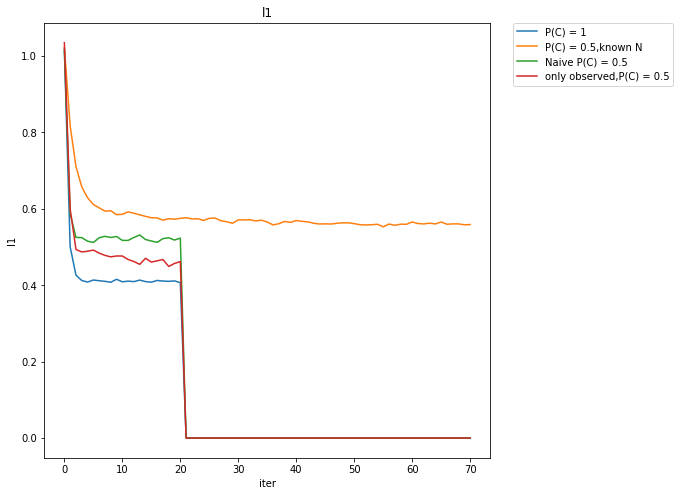

ValueError: All arrays must be of the same length

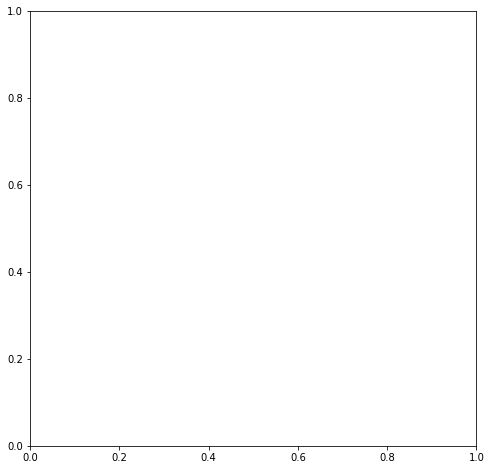

In [43]:


for all_results,name in zip([all_l1_results,all_ce_results],['l1','crossEntropy']) : 
    fig, sub = plt.subplots(1,1,figsize=(8, 8))
    model_results_df = pd.DataFrame(all_results)

    sns.lineplot(data=model_results_df, ax=sub, legend='full', dashes=False)
    sub.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sub.set_title(f"{name}")
    sub.set_xlabel("iter")
    sub.set_ylabel(f"{name}")

    plt.subplots_adjust(hspace=0.8)
    plt.subplots_adjust(wspace=0.8)

    plt.show()

In [30]:
gs = GibbsSampler(5)
gs._calc_alpha([0,2],[0,1],{(0,0):1,(0,1):1,(1,0):1,(1,1):0,(1,2):0.1})

0

In [14]:
transitions_results_list = [first_experiment_results['transitions'],second_experiment_results['transitions'],third_experiment_results['transitions'],fourth_experiment_results['transitions']]

In [15]:
alphas_results_list = [first_experiment_results['all_alphas'],second_experiment_results['all_alphas'],third_experiment_results['all_alphas'],fourth_experiment_results['all_alphas']]
experiments_name_list = [first_experiment_args['title'],second_experiment_args['title'],third_experiment_args['title'],fourth_experiment_args['title']]


<AxesSubplot:>

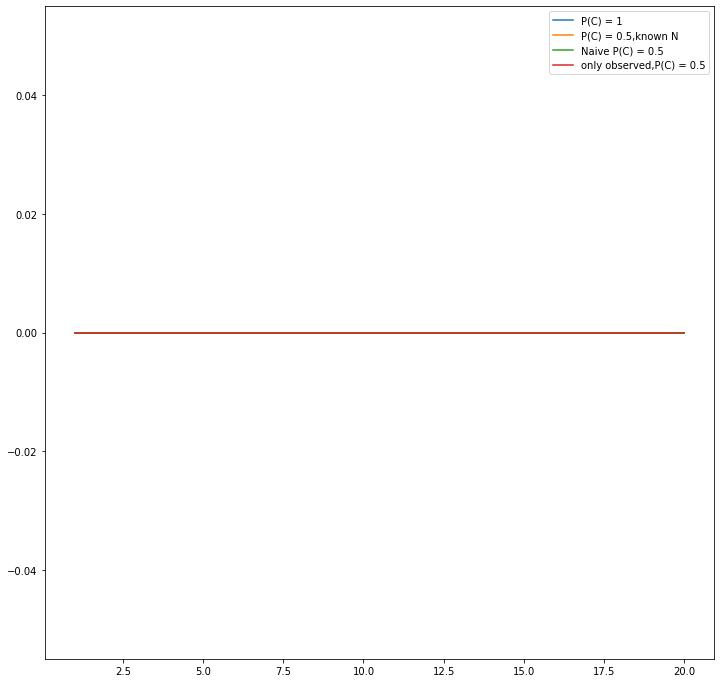

In [16]:
alphas_df = pd.DataFrame({k:v for k,v in zip(experiments_name_list,alphas_results_list)})

fig,sub = plt.subplots(1,figsize=(12,12))
alphas_df.plot(ax=sub)